In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
from os import listdir
from os.path import isfile, join

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import OPTICS
from sklearn.mixture import BayesianGaussianMixture 

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Dense, BatchNormalization
from tensorflow.keras.layers import Activation, LeakyReLU

import keras_radam
from keras_radam import RAdam
from tensorflow.keras.utils import plot_model

import numpy as np
import joblib 
import matplotlib.pyplot as plt

from CRISMrelatedMethods.preprocessing import *
from CRISMrelatedMethods.dataRead import *

## Augmented Data

In [2]:
spectralLibPath='../../spectralLibrary/'
Wstart,Wend=1.05,2.6
spectralWavelength,spectralIF,spectralFiles,mineralNames,spectralWavelengthSet=readSpectralLib(spectralLibPath,startW=Wstart,endW=Wend)

In [330]:
plebaniMICAclass={1:6, 2:12, 3:11, 4:16, 6:10, 7:24, 8:28, 9:18, 10:29, 11:0, 13:8, 18:1, 15:19, 17:7, 23:17, 25:2, 26:25, 27:15, 30:22, 31:5, 33:20, 35:13, 36:9, 37:4} #, 5:14, 19:27, 34:23, 16:3
plebaniMICAclass_rev={plebaniMICAclass[p]:p for p in plebaniMICAclass}

mineralGroupNames=['Iron oxides and primary silicates','Ices','Sulfates','Phyllosilicates','Carbonates','Hydrated silicates and halides']
mineralGroupList=[[14,23,9,26,20,13],[6,12],[0,27,25,3,18,11,16],[19,1,21,17,10,24,30,29,5],[8,22],[28,7,15,2,4]]
mineralGroupDict={g:G for G in range(len(mineralGroupList)) for g in mineralGroupList[G] }

In [179]:
perMineralAug=1000

X,y=[],[]
shiftAug=0
mineralCount=-1
mineralIndexMap={}
for file_index in range(len(spectralFiles)):
    if plebaniMICAclass_rev.get(file_index) is None: continue
    mineralCount+=1
    mineralIndexMap[mineralCount]=file_index
    interpFunc=interp1d(spectralWavelength[file_index],spectralIF[file_index], kind='linear')
    originalSpectra=interpFunc(spectralWavelengthSet)
    for i in range(perMineralAug):
        noisedSpectra=getContiNoised(getShiftNoised(originalSpectra),noiseStd=0.0075*(i%11),targetWL=spectralWavelengthSet)
        X.append(noisedSpectra)
        y.append(mineralCount)  
X=np.array(X)
y=np.array(y) 

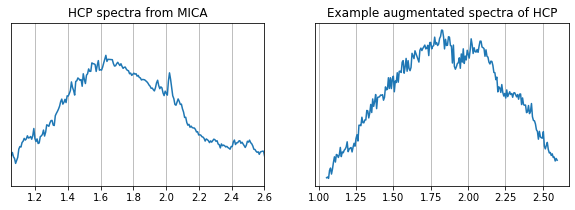

In [16]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(spectralWavelength[13],spectralIF[13])
plt.xlim(Wstart,Wend)
plt.ylim(.17,.2)
plt.yticks([])
plt.grid()
plt.title('HCP spectra from MICA')
plt.subplot(1,2,2)
plt.plot(spectralWavelengthSet,X[13013])
plt.yticks([])
plt.grid()
plt.title('Example augmentated spectra of HCP')
plt.show()

## Labelled Test Data

Downloaded from https://cs.iupui.edu/~mdundar/CRISM.htm (‘Ratioed training dataset for mineral classes’)

In [5]:
plebaniMICA_X,plebaniMICA_Y=getPlebaniData('../../CRISM_labeled_pixels_ratioed',plebaniMICAclass,spectralWavelengthSet,perLabelData=100)  # 100 spectra per class

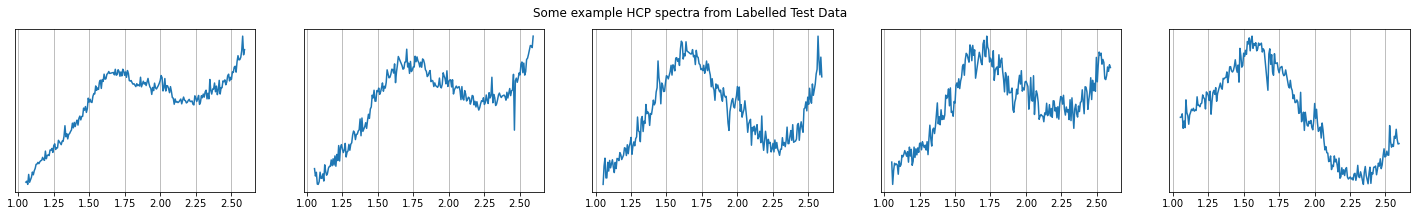

In [6]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X[1900+i])
    plt.yticks([])
    plt.grid()
plt.show()

## Pre-processing

smoothing

In [7]:
plebaniMICA_X_sm=getSmoothedData(plebaniMICA_X)
X_sm=getSmoothedData(X)

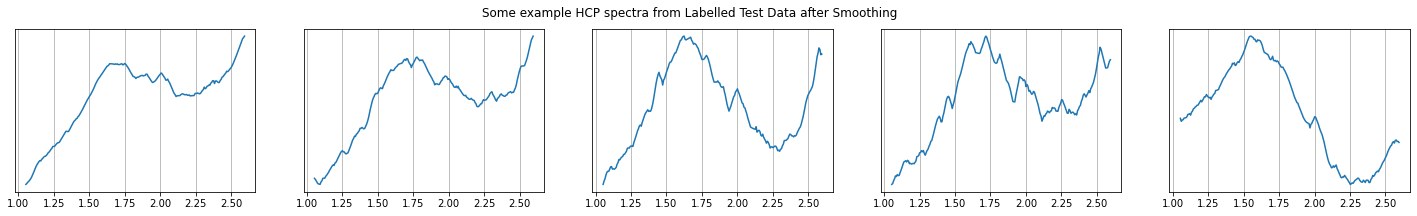

In [8]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data after Smoothing')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X_sm[1900+i])
    plt.yticks([])
    plt.grid()
plt.show()

continuum removal

In [9]:
plebaniMICA_X_smCR=getContinuumRemovedData(plebaniMICA_X_sm)
X_smCR=getContinuumRemovedData(X_sm)

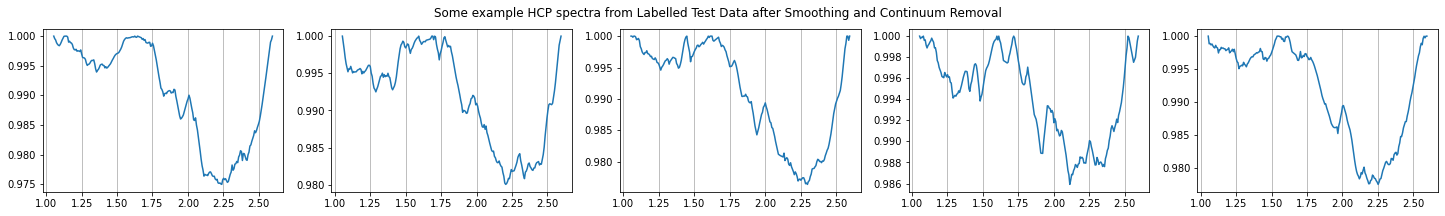

In [15]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data after Smoothing and Continuum Removal')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X_smCR[1900+i])
    plt.gca().xaxis.grid(True)
plt.show()

standard scaler

In [17]:
plebaniMICA_X_smCRSS=getStandardScaledData(plebaniMICA_X_smCR)
X_smCRSS=getStandardScaledData(X_smCR)

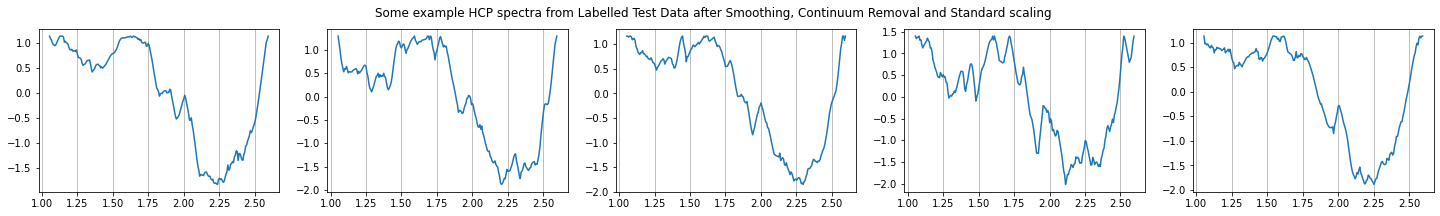

In [18]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data after Smoothing, Continuum Removal and Standard scaling')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X_smCRSS[1900+i])
    plt.gca().xaxis.grid(True)
plt.show()

Absorption Feature Extraction

In [54]:
P=getDiversePositions(spectralIF,spectralWavelength,spectralWavelengthSet)
X_smCRSSFE=getFeatureData(X_smCRSS,P)
plebaniMICA_X_smCRSSFE=getFeatureData(plebaniMICA_X_smCRSS,P)

## Models

In [318]:
def getLabelPairing(c_labels,y_labels):
    cUnique=list(np.unique(c_labels))
    cSlices=[np.where(c_labels==i,True,False) for i in cUnique]
    yUnique=list(np.unique(y_labels))
    ySlices=[np.where(y_labels==i,True,False) for i in yUnique]

    matchMat=np.zeros((len(cUnique),len(yUnique)))
    for c in range(len(cSlices)):
        for yy in range(len(ySlices)):
            matchMat[c,yy]=np.sum(cSlices[c]&ySlices[yy])/np.sum(cSlices[c]|ySlices[yy])
            
    S=(np.dstack(np.unravel_index(np.argsort(-matchMat.ravel()), (len(cUnique),len(yUnique)))))[0]
    matched_yc,matched_cy={},{}
    for s in S:
        if matched_yc.get(yUnique[s[1]]) is None and matched_cy.get(cUnique[s[0]]) is None:
            matched_yc[yUnique[s[1]]]=cUnique[s[0]]
            matched_cy[cUnique[s[0]]]= yUnique[s[1]]
    return matched_cy

def getGroupPred(pred):        
    return np.array([mineralGroupDict[p] for p in pred])

def getClassWiseAccuracy(c_labels,y_labels):
    cSlices={i:np.where(c_labels==i,True,False) for i in np.unique(c_labels)}
    ySlices={i:np.where(y_labels==i,True,False) for i in np.unique(y_labels)}
    return {i:np.sum(cSlices[i]&ySlices[i])/np.sum(cSlices[i]) for i in cSlices}

--------------------------------------------------------------------
Artificial Neural Network (ANN)

In [92]:
trainingData=X_smCRSSFE

tf.keras.backend.clear_session()
trainingData_rs = trainingData.reshape(trainingData.shape[0],trainingData.shape[1])
X_train,X_test,y_train,y_test = train_test_split(trainingData_rs,y,test_size=0.25,random_state=20)
newYTrain = to_categorical(y_train)
newYTest = to_categorical(y_test)

model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(newYTrain.shape[1], activation='softmax'))

loss='categorical_crossentropy'
optimizer = RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-5)
metrics=['accuracy']
model.compile(loss=loss, optimizer=optimizer , metrics=metrics)
        
totalEpochs=0
batch_size=240
epochs=50
totalEpochs+=epochs      
fitHistory = model.fit(X_train, newYTrain, validation_data=(X_test, newYTest), epochs=epochs,batch_size = batch_size, verbose=0)   

Ppredict=(model.predict(plebaniMICA_X_smCRSSFE))
Plabel=np.array([mineralIndexMap[np.argmax(Ppredict[p])] for p in range(Ppredict.shape[0])])

print('individual mineral',np.sum(np.where(Plabel==plebaniMICA_Y,True,False))/plebaniMICA_Y.shape[0])
print('mineral group',np.sum(np.where(getGroupPred(Plabel)==getGroupPred(plebaniMICA_Y),True,False))/plebaniMICA_Y.shape[0])

individual mineral 0.78125
mineral group 0.8258333333333333


In [95]:
print("predicted labels for example 'hcp' class: ",[mineralNames[p] for p in Plabel[1900:1905]])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'hcp', 'hcp']


In [83]:
model.save('models/ANN_smCRSSFE.h5')

In [347]:
Ppredict=(model.predict(plebaniMICA_X_smCRSSFE))
Plabel=np.array([mineralIndexMap[np.argmax(Ppredict[p])] for p in range(Ppredict.shape[0])])

G=getClassWiseAccuracy(getGroupPred(Plabel),getGroupPred(plebaniMICA_Y))
[(mineralGroupNames[g], np.round(G[g],4)) for g in G]

[('Iron oxides and primary silicates', 0.8263),
 ('Ices', 0.9886),
 ('Sulfates', 0.9326),
 ('Phyllosilicates', 0.8233),
 ('Carbonates', 0.5),
 ('Hydrated silicates and halides', 0.7414)]

---------------------------------------------------------------------------------------------------------------------
Random Forest Classifier (RFC)

In [344]:
rfc=RandomForestClassifier(n_estimators=100, bootstrap=True, warm_start=True).fit(X_smCRSSFE, y.ravel())

y_=rfc.predict(plebaniMICA_X_smCRSSFE)
c_label=np.array([mineralIndexMap[y_[p]] for p in range(y_.shape[0])])

print('individual mineral',np.sum(np.where(c_label==plebaniMICA_Y,True,False))/plebaniMICA_Y.shape[0])
print('mineral group',np.sum(np.where(getGroupPred(c_label)==getGroupPred(plebaniMICA_Y),True,False))/plebaniMICA_Y.shape[0])

individual mineral 0.7520833333333333
mineral group 0.8145833333333333


In [96]:
print("predicted labels for example 'hcp' class: ",[mineralNames[p] for p in c_label[1900:1905]])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'hcp', 'hcp']


In [86]:
joblib.dump(rfc,'models/RFC_smCRSSFE.z')

['RFC_smCRSSFE.z']

In [345]:
G=getClassWiseAccuracy(getGroupPred(c_label),getGroupPred(plebaniMICA_Y))
[(mineralGroupNames[g], np.round(G[g],4)) for g in G]

[('Iron oxides and primary silicates', 0.7967),
 ('Ices', 0.9451),
 ('Sulfates', 0.9191),
 ('Phyllosilicates', 0.8365),
 ('Carbonates', 0.5034),
 ('Hydrated silicates and halides', 0.8401)]

-----------------------------------------------------------------------------------------
Support Vector Classifier (SVC)

In [342]:
pca=PCA(.95)
pca.fit(X_smCRSSFE)

svc=SVC(tol=1e-3, kernel='rbf',gamma='scale',C=1).fit(pca.transform(X_smCRSSFE),y.ravel())

y_=svc.predict(pca.transform(plebaniMICA_X_smCRSSFE))
c_label=np.array([mineralIndexMap[y_[p]] for p in range(y_.shape[0])])

print('individual mineral',np.sum(np.where(c_label==plebaniMICA_Y,True,False))/plebaniMICA_Y.shape[0])
print('mineral group',np.sum(np.where(getGroupPred(c_label)==getGroupPred(plebaniMICA_Y),True,False))/plebaniMICA_Y.shape[0])

individual mineral 0.74625
mineral group 0.8079166666666666


In [97]:
print("predicted labels for example 'hcp' class: ",[mineralNames[p] for p in c_label[1900:1905]])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'hcp', 'hcp']


In [89]:
joblib.dump(pca,'models/PCA_smCRSSFE.z')
joblib.dump(svc,'models/SVC_smCRSSFE.z')

['SVC_smCRSSFE.z']

In [343]:
G=getClassWiseAccuracy(getGroupPred(c_label),getGroupPred(plebaniMICA_Y))
[(mineralGroupNames[g], np.round(G[g],4)) for g in G]

[('Iron oxides and primary silicates', 0.7855),
 ('Ices', 0.9774),
 ('Sulfates', 0.8923),
 ('Phyllosilicates', 0.8082),
 ('Carbonates', 0.5802),
 ('Hydrated silicates and halides', 0.7894)]

--------------------------------------------------------
Ordering Points To Identify Clustering Structure (OPTICS)

In [340]:
clustering = OPTICS(min_samples=.005, algorithm='brute',xi=.001,metric='correlation',min_cluster_size=.01).fit(plebaniMICA_X_smCRSS)
labels=clustering.labels_

labels-=np.min(labels)
labelPairing= getLabelPairing(labels, plebaniMICA_Y)
c_label=np.array([labelPairing[labels[l]] for l in range(labels.shape[0])])

print('individual mineral',np.sum(np.where(c_label==plebaniMICA_Y,True,False))/plebaniMICA_Y.shape[0])
print('mineral group',np.sum(np.where(getGroupPred(c_label)==getGroupPred(plebaniMICA_Y),True,False))/plebaniMICA_Y.shape[0])

individual mineral 0.5070833333333333
mineral group 0.6675


In [241]:
print("predicted labels for example 'hcp' class: ",[mineralNames[labelPairing[p]] for p in labels[1900:1905]])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'serpentine', 'hcp']


In [341]:
G=getClassWiseAccuracy(getGroupPred(c_label),getGroupPred(plebaniMICA_Y))
[(mineralGroupNames[g], np.round(G[g],4)) for g in G]

[('Iron oxides and primary silicates', 0.9767),
 ('Ices', 1.0),
 ('Sulfates', 0.9838),
 ('Phyllosilicates', 0.469),
 ('Carbonates', 1.0),
 ('Hydrated silicates and halides', 0.9723)]

----------------------------------------------------------------
linear discriminant analysis (LDA)

In [336]:
X_train,X_test,y_train,y_test = train_test_split(plebaniMICA_X_smCRSS,plebaniMICA_Y,test_size=0.3,random_state=20)
lda = LDA(shrinkage=1,solver='lsqr').fit(X_train, y_train)
    
y_=lda.predict(X_test)

print('individual mineral',np.sum(np.where(y_==y_test,True,False))/y_test.shape[0])
print('mineral group',np.sum(np.where(getGroupPred(y_)==getGroupPred(y_test),True,False))/y_test.shape[0])

individual mineral 0.7986111111111112
mineral group 0.8444444444444444


In [324]:
print("predicted labels for example 'hcp' class: ",[mineralNames[p] for p in lda.predict(plebaniMICA_X_smCRSS[1900:1905])])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'hcp', 'hcp']


In [337]:
G=getClassWiseAccuracy(getGroupPred(y_),getGroupPred(y_test))
[(mineralGroupNames[g], np.round(G[g],4)) for g in G]

[('Iron oxides and primary silicates', 0.696),
 ('Ices', 0.8769),
 ('Sulfates', 0.9597),
 ('Phyllosilicates', 0.8876),
 ('Carbonates', 0.6226),
 ('Hydrated silicates and halides', 0.8667)]

----------------------------------------------------
Bayesian Gaussian Dirichlet Process Mixture (DPM)

In [333]:
pca=PCA(.95)
pca.fit(plebaniMICA_X_smCRSS)
    
X_train,X_test,y_train,y_test = train_test_split(plebaniMICA_X_smCRSS,plebaniMICA_Y,test_size=0.2) #,random_state=20
dpm = BayesianGaussianMixture(weight_concentration_prior_type='dirichlet_process',n_components=np.unique(y_train).shape[0], random_state=1,warm_start=True).fit(pca.transform(X_train), y_train)
    
y_=dpm.predict(pca.transform(X_test))
labelPairing= getLabelPairing(y_, y_test)
c_label=np.array([labelPairing[y_[l]] for l in range(y_.shape[0])])

print('individual mineral',np.sum(np.where(c_label==y_test,True,False))/y_test.shape[0])
print('mineral group',np.sum(np.where(getGroupPred(c_label)==getGroupPred(y_test),True,False))/y_test.shape[0])

individual mineral 0.6791666666666667
mineral group 0.7833333333333333


In [328]:
print("predicted labels for example 'hcp' class: ",[mineralNames[labelPairing[p]] for p in dpm.predict(pca.transform(plebaniMICA_X_smCRSS[1900:1905]))])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'hcp', 'hcp']


In [335]:
G=getClassWiseAccuracy(getGroupPred(c_label),getGroupPred(y_test))
[(mineralGroupNames[g], np.round(G[g],4)) for g in G]

[('Iron oxides and primary silicates', 0.8788),
 ('Ices', 1.0),
 ('Sulfates', 0.925),
 ('Phyllosilicates', 0.7748),
 ('Carbonates', 0.9444),
 ('Hydrated silicates and halides', 0.5833)]